In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

# stats
from scipy.stats import ncx2, norm

In [2]:
# notebook parameters

n_samples = 10000
random_seed = 1

step_size = 0.15

In [3]:
# milstein method
def milstein(yn_, h_, drift_, diffusivity_, diffusivity_derivative_, rng_):
    dW1 = rng_.normal(loc=0, scale=1, size=yn_.shape)
    # dW2 = rng_.normal(loc=0, scale=np.sqrt(h_), size=yn_.shape)
    b = diffusivity_(yn_)
    bprime = diffusivity_derivative_(yn_)
    ynp1 = yn_ + h_*drift_(yn_) + b * np.sqrt(h_) * dW1 + 0.5 * b * bprime * (h_ * dW1**2-h_)
    return ynp1


# euler method
def euler(yn_, h_, drift_, diffusivity_, diffusivity_derivative_, rng_):
    dW1 = rng_.normal(loc=0, scale=np.sqrt(h_), size=yn_.shape)
    # dW1 = rng_.normal(loc=0, scale=np.sqrt(h_), size=yn_.shape)
    b = diffusivity_(yn_)
    # bprime = diffusivity_derivative_(yn_)
    ynp1 = yn_ + h_*drift_(yn_) + b * dW1  # + 0.5 * b * bprime * (dW2**2-h_)
    return ynp1


def euler_pdf(pdf_x, yn_, h_, drift_, diffusivity_):
    return norm.pdf(pdf_x, loc=yn_+drift_(yn_)*h_, scale=np.abs(diffusivity_(yn_))* np.sqrt(h_))


def milstein_pdf(pdf_x, yn_, h_, drift_, diffusivity_, diffusivity_derivative_):
    bprime = diffusivity_derivative_(yn_)
    b = (diffusivity_(yn_))
    A = yn_ + drift_(yn_) * h_ - 0.5 * b * bprime * h_
    B = b * np.sqrt(h_)
    C = np.clip(0.5 * b * bprime * h_, 1e-15, 1e15)

    nc_lambda = np.power(B/(2*C), 2)

    mean_ = -(- A + B**2 / (4*C))
    pdf_x_ = (pdf_x-mean_)/C  # + (- A + B**2 / (4*C))) / C
    # pdf_x_ = (pdf_x * C - (- A + B**2 / (4*C)))
    chi2_ = ncx2.pdf(pdf_x_, df=1, nc=nc_lambda, loc=0, scale=1) / C

    print(C)
    f = 1  # -np.exp(-np.abs(C)**2/100)

    return chi2_ * f + euler_pdf(pdf_x, yn_, h_, drift_, diffusivity_) * (1-f)

0.03844313437499999


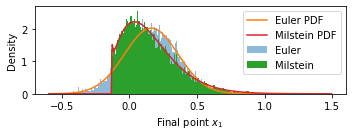

In [4]:
# example 1
gbm_mu = 1
gbm_sigma = 1


def f1(y):
    return gbm_mu*y+1


def s1(y):
    return 1/4*y**2+y+1/2


def s1prime(y):
    return 1/2*y+1


rng = np.random.default_rng(random_seed)

yn0 = .01
yn = np.zeros((n_samples,))+yn0

rng = np.random.default_rng(random_seed)
ynp1_milstein = milstein(yn, step_size, f1, s1, s1prime, rng)

# recreate the same random points
rng = np.random.default_rng(random_seed)
ynp1_euler = euler(yn, step_size, f1, s1, s1prime, rng)

bmin = np.min([ynp1_milstein, ynp1_euler])
bmax = np.max([ynp1_milstein, ynp1_euler])

bins = np.linspace(bmin, bmax, 250)
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
ax.hist(ynp1_euler, bins, alpha=0.5, label="Euler", density=True);
ax.plot(bins, euler_pdf(bins, yn0, step_size, f1, s1), label='Euler PDF')

ax.hist(ynp1_milstein, bins, label="Milstein", density=True);
ax.plot(bins, milstein_pdf(bins, yn0, step_size, f1, s1, s1prime), label='Milstein PDF')

ax.set_xlabel(r"Final point $x_1$")
ax.set_ylabel("Density")
ax.legend();

fig.tight_layout()

fig.savefig("figures/density_milstein_vs_euler.pdf")

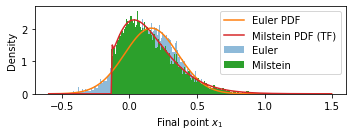

In [7]:
# now see if we can use tensorflow to write the PDF as well

import tensorflow as tf
#import tensorflow_probability as tfp

# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')


def milstein_pdf_tfp(pdf_x, yn_, h_, drift_, diffusivity_):

    with tf.GradientTape() as g:
        g.watch(yn_)
        b = diffusivity_(yn_)
    bprime = g.gradient(b, yn_)
    # b = diffusivity_(yn_ )
    A = yn_ + drift_(yn_) * h_ - 0.5 * b * bprime * h_
    B = b * tf.cast(tf.math.sqrt(h_), tf.float64)
    C = tf.clip_by_value(0.5 * b * bprime * h_, 1e-15, 1e15)

    nc_lambda = (B/(2*C))**2
    k_dof = 1
    x = (pdf_x + (-A + (B**2)/(4*C))) / C

    # we use the bessel function of order 0 instead of -1/2 here... maybe a problem
    p_xi = 0.5 * tf.math.exp(-(x+nc_lambda)/2) * tf.pow(x/nc_lambda, k_dof/4-1/2) * tf.math.bessel_i0(tf.math.sqrt(nc_lambda*x)) / C

    p_xi = tf.where(tf.math.is_nan(p_xi), tf.zeros_like(p_xi), p_xi)
    p_xi = tf.clip_by_value(p_xi, 1e-15, 1e15)
    return p_xi

yn_tensor = tf.convert_to_tensor([yn0], dtype=tf.float64)
bins_tensor = tf.convert_to_tensor(bins.reshape(-1,), dtype=tf.float64)
ynp1_milstein_tf_pdf = milstein_pdf_tfp(bins_tensor, yn_tensor, step_size, f1, s1)

# print(ynp1_milstein_tf_pdf.numpy())

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
ax.hist(ynp1_euler, bins, alpha=0.5, label="Euler", density=True);
ax.plot(bins, norm.pdf(bins, loc=yn0+f1(yn0)*step_size, scale=s1(yn0)*np.sqrt(step_size)), label='Euler PDF')

ax.hist(ynp1_milstein, bins, label="Milstein", density=True);
ax.plot(bins, ynp1_milstein_tf_pdf.numpy(), label='Milstein PDF (TF)')

ax.set_xlabel(r"Final point $x_1$")
ax.set_ylabel("Density")
ax.legend()

fig.tight_layout()

fig.savefig("figures/density_milstein_vs_euler_tf.pdf")

(10000,)
0.005


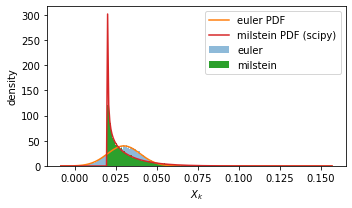

In [15]:
import tensorflow_probability as tfp

tfd = tfp.distributions


def milstein_tfp(yn_, h_, drift_, diffusivity_, diffusivity_derivative_):
    b = diffusivity_(yn_)
    bprime = diffusivity_derivative_(yn_)
    approx_normal = tfd.MultivariateNormalDiag(
                loc=yn_*0,
                scale_diag=yn_*0+tf.reshape(tf.cast(1, tf.float64), (1,)),
                name="approx_normal"
            )
    dW1 = approx_normal.sample()
    ynp1 = yn_ + h_*drift_(yn_) + b * np.sqrt(h_) * dW1 + 0.5 * b * bprime * (h_ * dW1**2-h_)
    return ynp1


def milstein_tfp_approx(pdf_x, yn_, h_, drift_, diffusivity_, diffusivity_derivative_, scale_per_point=1e-3):
    ynp1_ = milstein_tfp(yn_, h_, drift_, diffusivity_, diffusivity_derivative_)
    probs = tf.ones_like(ynp1_, dtype=tf.float64)/tf.cast(tf.shape(ynp1_)[0], tf.float64)
    components = [
          tfd.Normal(loc=ynp1_[k], scale=tf.cast(scale_per_point, dtype=tf.float64))
          for k in range(tf.shape(ynp1_)[-1])
    ]
    mix_gauss = tfd.Mixture(
      cat=tfd.Categorical(probs=probs),
      components=components)
    return mix_gauss.log_prob(pdf_x)


rng = np.random.default_rng(random_seed)

yn0 = .01
yn = np.zeros((n_samples,))+yn0

rng = np.random.default_rng(random_seed)
ynp1_milstein = tf.keras.backend.eval(milstein_tfp(yn, step_size, f1, s1, s1prime))

print(ynp1_milstein.shape)

# recreate the same random points
rng = np.random.default_rng(random_seed)
ynp1_euler = euler(yn, step_size, f1, s1, s1prime, rng)

bmin = np.min([ynp1_milstein, ynp1_euler])
bmax = np.max([ynp1_milstein, ynp1_euler])

bins = np.linspace(bmin, bmax, 250)
bins_tensor = tf.convert_to_tensor(bins.reshape(-1,), dtype=tf.float64)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(ynp1_euler, bins, alpha=0.5, label="euler", density=True);
ax.plot(bins, euler_pdf(bins, yn0, step_size, f1, s1), label='euler PDF')

ax.hist(ynp1_milstein, bins, label="milstein", density=True);
ax.plot(bins, milstein_pdf(bins, yn0, step_size, f1, s1, s1prime), label='milstein PDF (scipy)')

ax.set_xlabel(r"$X_k$")
ax.set_ylabel("density")
ax.legend();

fig.tight_layout()

0.005
0.005


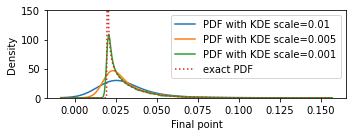

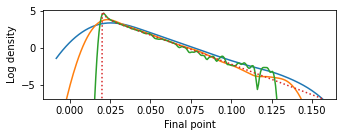

In [21]:

fig1, ax1 = plt.subplots(1, 1, figsize=(5, 2))
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 2))

for scale_per_point in [1e-2, 5e-3, 1e-3]:
    mtfp = milstein_tfp_approx(bins_tensor, yn, step_size, f1, s1, s1prime, scale_per_point=scale_per_point)

    ax1.plot(bins, tf.exp(mtfp), '-', label=f'PDF with KDE scale={scale_per_point}')
    ax1.set_xlabel(r"Final point")
    ax1.set_ylabel("Density")
    ax2.plot(bins, mtfp, '-', label=f'PDF with KDE scale={scale_per_point}')
    ax2.set_xlabel(r"Final point")
    ax2.set_ylabel("Log density")
ax1.plot(bins, milstein_pdf(bins, yn0, step_size, f1, s1, s1prime), ":", label='exact PDF')
ax1.set_ylim([0, (150)])
ax1.legend();
fig1.tight_layout()

ax2.plot(bins, np.log(milstein_pdf(bins, yn0, step_size, f1, s1, s1prime)+1e-15), ":", label='Exact PDF')
ax2.set_ylim([np.log(1e-3), np.log(180)])
#ax2.legend();
fig2.tight_layout()

fig1.savefig("figures/density_milstein_approx.pdf")
fig1.savefig("figures/density_milstein_approx.png")
fig2.savefig("figures/density_milstein_approx_log.png")
fig2.savefig("figures/density_milstein_approx_log.pdf")

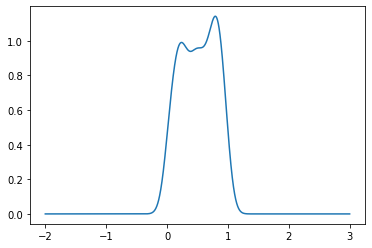

In [94]:
# Create a mixture of n Gaussians:

rng = np.random.default_rng(random_seed)

n_samples_gmix = 100
yn0 = .01
yn_ = rng.uniform(low=0, high=1, size=(n_samples_gmix,))

probs = tf.ones_like(yn_, dtype=tf.float64)/tf.cast(tf.shape(yn_)[0], tf.float64)
components = [
      tfd.Normal(loc=yn_[k], scale=tf.cast(0.1, dtype=tf.float64))
      for k in range(tf.shape(yn_)[-1])
]

bimix_gauss = tfd.Mixture(
  cat=tfd.Categorical(probs=probs),
  components=components)

# Plot the PDF.
import matplotlib.pyplot as plt
x = tf.linspace(-2., 3., int(1e4))
plt.plot(x, bimix_gauss.prob(tf.cast(x, dtype=tf.float64)))


0.005
0.005


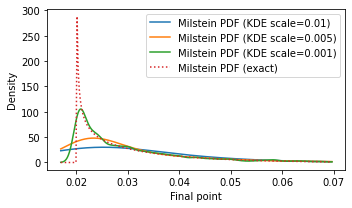

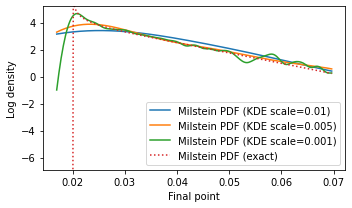

In [97]:
def milstein_forward(eval_at_y_, yn_, h_, model_, scale_per_point=1e-3):
    """
    One forward pass of the Milstein method, implemented using TensorFlow.

    Parameters
    ----------
    yn_ current step
    h_ time step size at current step
    model_ keras.Model that returns a tuple of (drift,diffusivity matrix)

    Returns
    -------
    y(n+1) estimated using the Milstein scheme.
    """
    # with tf.GradientTape() as g:
    #     g.watch(yn_)
    #     drift_, diffusivity_ = model_(yn_)
    # diffusivity_prime_ = g.gradient(diffusivity_, yn_)
    drift_, diffusivity_, diffusivity_prime_ = model_[0](yn_), model_[1](yn_), model_[2](yn_)

    approx_normal = tfd.MultivariateNormalDiag(
        loc=tf.zeros_like(yn_),
        scale_diag=tf.ones_like(yn_)
    )
    z = approx_normal.sample()
    sqrt_h = tf.cast(tf.math.sqrt(h_), dtype=tf.float64)
    ynp1 = yn_ + h_ * drift_ + diffusivity_ * sqrt_h * z + 0.5 * diffusivity_ * diffusivity_prime_ * (h_ * z ** 2 - h_)

    kde_single_gaussian = tfd.Normal(loc=ynp1, scale=tf.cast(scale_per_point, dtype=tf.float64))
    return tf.reduce_mean(tf.map_fn(lambda y_: kde_single_gaussian.prob(y_), eval_at_y_), axis=1)

def milstein_forward_approx(evaluate_at_y, yn_, h_, model_, scale_per_point=1e-3, num_estimations=100):
    """
    Estimation of the PDF of Milstein scheme, using a Gaussian Kernel Density estimate.

    Parameters
    ----------
    evaluate_at_y where to evaluate the pdf? Should be y(n+1)
    yn_ the given points y(n)
    h_ time step size at y(n)
    model_ keras.Model that returns (drift, diffusivity matrix) tuple
    scale_per_point kernel density estimator scale per point. Should scale with the number of points in yn_.
    num_estimations number of estimations, i.e. number of random numbers we draw from the Gaussian.

    Returns
    -------

    """
    yn_repeated = tf.expand_dims(yn_, axis=0)
    yn_repeated = tf.tile(yn_repeated, (num_estimations, 1, 1))
    probabilities = tf.map_fn(lambda y_: milstein_forward(evaluate_at_y, y_, h_,
                                                          model_,
                                                          scale_per_point=scale_per_point), yn_repeated)

    return tf.math.log(tf.reduce_mean(probabilities, axis=0))


num_estimations = 100

fig1, ax1 = plt.subplots(1, 1, figsize=(5, 3))
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 3))

for scale_per_point in [1e-2, 5e-3, 1e-3]:
    mtfp = milstein_forward_approx(tf.reshape(bins_tensor, (-1, 1)), yn.reshape(-1, 1), step_size,
                                   (f1, s1, s1prime),
                                   scale_per_point=scale_per_point,
                                   num_estimations=num_estimations)

    ax1.plot(bins, tf.exp(mtfp), '-', label=f'Milstein PDF (KDE scale={scale_per_point})')
    ax1.set_xlabel(r"Final point")
    ax1.set_ylabel("Density")
    ax2.plot(bins, mtfp, '-', label=f'Milstein PDF (KDE scale={scale_per_point})')
    ax2.set_xlabel(r"Final point")
    ax2.set_ylabel("Log density")
ax1.plot(bins, milstein_pdf(bins, yn0, step_size, f1, s1, s1prime), ":", label='Milstein PDF (exact)')
ax1.legend();
fig1.tight_layout()

ax2.plot(bins, np.log(milstein_pdf(bins, yn0, step_size, f1, s1, s1prime)+1e-15), ":", label='Milstein PDF (exact)')
ax2.set_ylim([np.log(1e-3), np.log(180)])
ax2.legend();
fig2.tight_layout()


In [98]:
num_estimations = 10
h_ = 1.
yn_b = yn_.reshape(-1, 2)
print(yn_b.shape)
probabilities = tf.ones_like(tf.range(num_estimations), dtype=tf.float64) / num_estimations
yn_repeated = tf.repeat(yn_b, num_estimations, axis=0)
locs = tf.map_fn(lambda y_: y_**2, yn_repeated)

print(locs.shape)

(50, 2)
(500, 2)
